In [1]:
"""
Author: Bryan Bo Cao
Email: boca7588@colorado.edu or bo.cao-1@colorado.edu
Github Repo: https://github.com/BryanBo-Cao/neuralnets-deeplearning
Reference:
    http://www.deeplearning.net/tutorial/lstm.html#lstm
    https://github.com/llSourcell/LSTM_Networks/blob/master/LSTM%20Demo.ipynb
    https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/recurrent_network.py
    Recurrent Neural Network.
    A Recurrent Neural Network (LSTM) implementation example using TensorFlow library.
    This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
    Links:
    [Long Short Term Memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
    [MNIST Dataset](http://yann.lecun.com/exdb/mnist/).
    Author: Aymeric Damien
    Project: https://github.com/aymericdamien/TensorFlow-Examples/
"""
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from importlib import import_module

H = 5
N = 25

#Reference: Denis
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    return np.expand_dims(sequences, axis=2), y

#Reference: Modified from Denis by Bo Cao
def generate_parity_sequences(N, count):
    """
    Generate :count: sequences of length :N:.
    If odd # of 1's -> output 1
    else -> output 0
    """
    xor = lambda x: 1 if (x % 2 == 1) else 0
    sequences = np.random.choice([0, 1], size=[count, N], replace=True)
    counts = np.count_nonzero(sequences == 1, axis=1)
    # xor each sequence, expand dimensions by 1 to match sequences shape
    y = np.expand_dims(np.array([xor(x) for x in counts]), axis=1)

    # In case if you wanted to have the answer just appended at the end of the sequence:
    #     # append the answer at the end of each sequence
    #     seq_plus_y = np.concatenate([sequences, y], axis=1)
    #     print(sequences.shape, y.shape, seq_plus_y.shape)
    #     return seq_plus_y
    
    new_y = []
    for i in range(len(y)):
        new_yy = []
        if y[i] == 0:
            new_yy.append(0)
            new_yy.append(1)
        else:
            new_yy.append(1)
            new_yy.append(0)
        new_y.append(new_yy)

    return np.expand_dims(sequences, axis=2), new_y

In [2]:
# Training Parameters
learning_rate = 0.3
batch_size = 128
display_step = batch_size * 100

#batch_steps = 10000 / batch_size
epochs = 1000

# Network Parameters
num_input = 1 # 
timesteps = N # timesteps
num_hidden = H # hidden layer num of features
num_classes = 2 # 0 or 1

# tf Graph input
X = tf.placeholder("float", [None, timesteps, num_input])
Y = tf.placeholder("float", [None, num_classes])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}


def RNN(x, weights, biases):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, timesteps, n_input)
    # Required shape: 'timesteps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a RNN cell with tensorflow
    rnn_cell = rnn.BasicRNNCell(num_hidden)

    # Get RNN cell output
    outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

logits = RNN(X, weights, biases)
#prediction = tf.nn.softmax(logits)
prediction = tf.tanh(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

test_accuracies_10replications = []
losses_1st_replication = [] #epoch as unit
test_accuracies_1st_replication = [] #epoch as unit
train_accuracies_1st_replication = [] #epoch as unit

# Start training
with tf.Session() as sess:
    
    # Run 10 replications
    for replication in range(10):
        
        print("Replication: %d: " % replication)
        
        # Initialize random weights
        train_data = generate_parity_sequences(N, 10000)
        train_data_x = train_data[0]
        train_data_y = train_data[1]
        test_data = generate_parity_sequences(N, 10000)
        test_data_x = test_data[0]
        test_data_y = test_data[1]
        
        # Run the initializer
        sess.run(init)
    
        for epoch in range(epochs):
            batch_index = 0
            while batch_index < 10000:

                train_data_batch_x = []
                train_data_batch_y = []
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_x[batch_index : batch_index + batch_size]
                    train_data_batch_y = train_data_y[batch_index : batch_index + batch_size]
                else:
                    train_data_batch_x = train_data_x[batch_index : ]
                    train_data_batch_y = train_data_y[batch_index : ]

                #batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Reshape data to get 28 seq of 28 elements
                #batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                #train_data_x = train_data_x.reshape((10000, timesteps, num_input))
                #print("train_data_batch_x.shape:  " , train_data_batch_x.shape)
                if batch_index + batch_size < 10000: 
                    train_data_batch_x = train_data_batch_x.reshape((batch_size, timesteps, num_input))
                else:
                    train_data_batch_x = train_data_batch_x.reshape((10000 % batch_size, timesteps, num_input))
                # Run optimization op (backprop)
                #sess.run(train_op, feed_dict={X: train_data_x, 
                 #                             Y: train_data_y})
                sess.run(train_op, feed_dict={X: train_data_batch_x, 
                                              Y: train_data_batch_y})

                batch_index += batch_size

            if replication == 0:
                loss, train_accuracy = sess.run([loss_op, accuracy], feed_dict={X: train_data_x, Y: train_data_y})
                test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
                losses_1st_replication.append(loss)
                train_accuracies_1st_replication.append(train_accuracy)
                test_accuracies_1st_replication.append(test_accuracy)
            
            if epoch % 10 == 0:
                loss, acc = sess.run([loss_op, accuracy], feed_dict={X: train_data_x,
                                                                         Y: train_data_y})
                print("Epoch: " + str(epoch) + \
                          ", Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))

        print("Optimization Finished!")

        test_data_x = test_data_x.reshape((-1, timesteps, num_input))
        test_data_y = test_data_y
        test_accuracy = sess.run(accuracy, feed_dict={X: test_data_x, Y: test_data_y})
        test_accuracies_10replications.append(test_accuracy)
        print("Testing Accuracy:", test_accuracy)

Replication: 0: 
Epoch: 0, Loss= 0.6959, Training Accuracy= 0.506
Epoch: 10, Loss= 0.6949, Training Accuracy= 0.508
Epoch: 20, Loss= 0.6942, Training Accuracy= 0.512
Epoch: 30, Loss= 0.6937, Training Accuracy= 0.512
Epoch: 40, Loss= 0.6934, Training Accuracy= 0.511
Epoch: 50, Loss= 0.6932, Training Accuracy= 0.511
Epoch: 60, Loss= 0.6930, Training Accuracy= 0.513
Epoch: 70, Loss= 0.6929, Training Accuracy= 0.511
Epoch: 80, Loss= 0.6928, Training Accuracy= 0.512
Epoch: 90, Loss= 0.6928, Training Accuracy= 0.512
Epoch: 100, Loss= 0.6926, Training Accuracy= 0.512
Epoch: 110, Loss= 0.6925, Training Accuracy= 0.515
Epoch: 120, Loss= 0.6923, Training Accuracy= 0.513
Epoch: 130, Loss= 0.6923, Training Accuracy= 0.514
Epoch: 140, Loss= 0.6922, Training Accuracy= 0.516
Epoch: 150, Loss= 0.6922, Training Accuracy= 0.516
Epoch: 160, Loss= 0.6921, Training Accuracy= 0.516
Epoch: 170, Loss= 0.6920, Training Accuracy= 0.517
Epoch: 180, Loss= 0.6920, Training Accuracy= 0.518
Epoch: 190, Loss= 0.6920,

Epoch: 600, Loss= 0.6936, Training Accuracy= 0.504
Epoch: 610, Loss= 0.6925, Training Accuracy= 0.517
Epoch: 620, Loss= 0.6924, Training Accuracy= 0.520
Epoch: 630, Loss= 0.6926, Training Accuracy= 0.516
Epoch: 640, Loss= 0.6924, Training Accuracy= 0.517
Epoch: 650, Loss= 0.6927, Training Accuracy= 0.512
Epoch: 660, Loss= 0.6936, Training Accuracy= 0.507
Epoch: 670, Loss= 0.6926, Training Accuracy= 0.515
Epoch: 680, Loss= 0.6924, Training Accuracy= 0.518
Epoch: 690, Loss= 0.6936, Training Accuracy= 0.501
Epoch: 700, Loss= 0.6941, Training Accuracy= 0.499
Epoch: 710, Loss= 0.6944, Training Accuracy= 0.499
Epoch: 720, Loss= 0.6947, Training Accuracy= 0.499
Epoch: 730, Loss= 0.6945, Training Accuracy= 0.503
Epoch: 740, Loss= 0.6941, Training Accuracy= 0.502
Epoch: 750, Loss= 0.6943, Training Accuracy= 0.502
Epoch: 760, Loss= 0.6940, Training Accuracy= 0.506
Epoch: 770, Loss= 0.6940, Training Accuracy= 0.506
Epoch: 780, Loss= 0.6939, Training Accuracy= 0.505
Epoch: 790, Loss= 0.6938, Train

Epoch: 190, Loss= 0.6936, Training Accuracy= 0.514
Epoch: 200, Loss= 0.6940, Training Accuracy= 0.512
Epoch: 210, Loss= 0.6941, Training Accuracy= 0.512
Epoch: 220, Loss= 0.6943, Training Accuracy= 0.514
Epoch: 230, Loss= 0.6939, Training Accuracy= 0.514
Epoch: 240, Loss= 0.6930, Training Accuracy= 0.518
Epoch: 250, Loss= 0.6930, Training Accuracy= 0.515
Epoch: 260, Loss= 0.6990, Training Accuracy= 0.507
Epoch: 270, Loss= 0.6937, Training Accuracy= 0.511
Epoch: 280, Loss= 0.6930, Training Accuracy= 0.513
Epoch: 290, Loss= 0.6930, Training Accuracy= 0.514
Epoch: 300, Loss= 0.6930, Training Accuracy= 0.516
Epoch: 310, Loss= 0.6930, Training Accuracy= 0.518
Epoch: 320, Loss= 0.6928, Training Accuracy= 0.518
Epoch: 330, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 340, Loss= 0.6927, Training Accuracy= 0.520
Epoch: 350, Loss= 0.6934, Training Accuracy= 0.515
Epoch: 360, Loss= 0.6931, Training Accuracy= 0.519
Epoch: 370, Loss= 0.6932, Training Accuracy= 0.516
Epoch: 380, Loss= 0.6939, Train

Epoch: 790, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 800, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 810, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 820, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 830, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 840, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 850, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 860, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 870, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 880, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 890, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 900, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 910, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 920, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 930, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 940, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 950, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 960, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 970, Loss= 0.6931, Training Accuracy= 0.504
Epoch: 980, Loss= 0.6931, Train

Epoch: 380, Loss= 0.6967, Training Accuracy= 0.512
Epoch: 390, Loss= 0.6962, Training Accuracy= 0.512
Epoch: 400, Loss= 0.6959, Training Accuracy= 0.509
Epoch: 410, Loss= 0.6964, Training Accuracy= 0.512
Epoch: 420, Loss= 0.6968, Training Accuracy= 0.510
Epoch: 430, Loss= 0.6971, Training Accuracy= 0.513
Epoch: 440, Loss= 0.6971, Training Accuracy= 0.516
Epoch: 450, Loss= 0.6948, Training Accuracy= 0.512
Epoch: 460, Loss= 0.6938, Training Accuracy= 0.513
Epoch: 470, Loss= 0.6939, Training Accuracy= 0.514
Epoch: 480, Loss= 0.6941, Training Accuracy= 0.513
Epoch: 490, Loss= 0.6938, Training Accuracy= 0.515
Epoch: 500, Loss= 0.6938, Training Accuracy= 0.515
Epoch: 510, Loss= 0.7003, Training Accuracy= 0.509
Epoch: 520, Loss= 0.6999, Training Accuracy= 0.509
Epoch: 530, Loss= 0.6997, Training Accuracy= 0.509
Epoch: 540, Loss= 0.6994, Training Accuracy= 0.509
Epoch: 550, Loss= 0.6993, Training Accuracy= 0.509
Epoch: 560, Loss= 0.6992, Training Accuracy= 0.509
Epoch: 570, Loss= 0.6998, Train

Epoch: 980, Loss= 0.6934, Training Accuracy= 0.505
Epoch: 990, Loss= 0.6934, Training Accuracy= 0.505
Optimization Finished!
Testing Accuracy: 0.4937
Replication: 8: 
Epoch: 0, Loss= 0.7183, Training Accuracy= 0.498
Epoch: 10, Loss= 0.7009, Training Accuracy= 0.498
Epoch: 20, Loss= 0.6960, Training Accuracy= 0.498
Epoch: 30, Loss= 0.6953, Training Accuracy= 0.497
Epoch: 40, Loss= 0.6952, Training Accuracy= 0.498
Epoch: 50, Loss= 0.6951, Training Accuracy= 0.498
Epoch: 60, Loss= 0.6950, Training Accuracy= 0.498
Epoch: 70, Loss= 0.6950, Training Accuracy= 0.498
Epoch: 80, Loss= 0.6949, Training Accuracy= 0.498
Epoch: 90, Loss= 0.6949, Training Accuracy= 0.498
Epoch: 100, Loss= 0.6949, Training Accuracy= 0.498
Epoch: 110, Loss= 0.6949, Training Accuracy= 0.498
Epoch: 120, Loss= 0.6949, Training Accuracy= 0.498
Epoch: 130, Loss= 0.6949, Training Accuracy= 0.498
Epoch: 140, Loss= 0.6948, Training Accuracy= 0.501
Epoch: 150, Loss= 0.6949, Training Accuracy= 0.502
Epoch: 160, Loss= 0.6949, Tr

Epoch: 570, Loss= 0.6914, Training Accuracy= 0.525
Epoch: 580, Loss= 0.6915, Training Accuracy= 0.524
Epoch: 590, Loss= 0.6923, Training Accuracy= 0.514
Epoch: 600, Loss= 0.6916, Training Accuracy= 0.523
Epoch: 610, Loss= 0.6912, Training Accuracy= 0.527
Epoch: 620, Loss= 0.6924, Training Accuracy= 0.525
Epoch: 630, Loss= 0.6934, Training Accuracy= 0.503
Epoch: 640, Loss= 0.6933, Training Accuracy= 0.515
Epoch: 650, Loss= 0.6925, Training Accuracy= 0.517
Epoch: 660, Loss= 0.6940, Training Accuracy= 0.517
Epoch: 670, Loss= 0.6934, Training Accuracy= 0.511
Epoch: 680, Loss= 0.6944, Training Accuracy= 0.501
Epoch: 690, Loss= 0.6929, Training Accuracy= 0.521
Epoch: 700, Loss= 0.6945, Training Accuracy= 0.515
Epoch: 710, Loss= 0.6929, Training Accuracy= 0.518
Epoch: 720, Loss= 0.6934, Training Accuracy= 0.516
Epoch: 730, Loss= 0.6919, Training Accuracy= 0.527
Epoch: 740, Loss= 0.6935, Training Accuracy= 0.505
Epoch: 750, Loss= 0.6919, Training Accuracy= 0.520
Epoch: 760, Loss= 0.6944, Train

In [3]:
# print results
test_accuracies_10replications_std = np.std(test_accuracies_10replications, axis=0)
test_accuracies_10replications_std_mean = test_accuracies_10replications_std / np.square(10)
print("test_accuracies_10replications: ", test_accuracies_10replications)
print("mean of test_accuracies_10replications: ", np.mean(test_accuracies_10replications))
print("standard deviation of test_accuracies_10replications_std_mean: ", test_accuracies_10replications_std_mean)

test_accuracies_10replications:  [0.4971, 0.48410001, 0.5061, 0.5115, 0.51249999, 0.4966, 0.498, 0.4937, 0.50910002, 0.4914]
mean of test_accuracies_10replications:  0.50001
standard deviation of test_accuracies_10replications_std_mean:  8.93839262426e-05


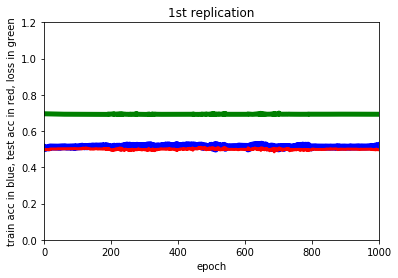

In [4]:
losses_1st_replication
plt.plot(losses_1st_replication, color='green', linewidth=5)
plt.plot(train_accuracies_1st_replication, color='blue', linewidth=7)
plt.plot(test_accuracies_1st_replication, color='red', linewidth=3)
plt.xlim(0, epochs)
plt.xlabel("epoch")
plt.ylim(0, 1.2)
plt.ylabel("train acc in blue, test acc in red, loss in green")
plt.title("1st replication")
plt.show()